## Example -- Taylor 2023

Example of using `optiwindnet` for routing the cables of a wind farm location with 122 turbines and 2 substations, which has a concave cable-laying area and one obstacle within that area.

Additional complexity on the geometry of the location has negligible impact on the solving time, as it does not increase the number of variables in the MILP model.

In [2]:
import pyomo.environ as pyo

In [3]:
from optiwindnet.api import WindFarmNetwork, Heuristic, MILP
from optiwindnet.importer import load_repository

load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Lib\site-packages\ortools\.libs\ortools.dll...


### Solvers

Using a MILP solver can produce better solutions. This notebook uses COIN-OR CBC but examples for other solvers can be found in the *MILP* notebooks.

There are some differences in solver parameters even for the ones supported through pyomo.

Gurobi and IBM ILOG CPLEX are comercial solvers (academic license available). Google's OR-Tools, COIN-OR CBC, SCIP and HiGHS are open-source software.

In [4]:
cbcer = pyo.SolverFactory('cbc')
cbcer.available(), type(cbcer)

(True, pyomo.solvers.plugins.solvers.CBCplugin.CBCSHELL)

### Load input data

In [13]:
file_path = '../../optiwindnet/data/Taylor-2023.yaml'
wfn = WindFarmNetwork.from_yaml(filepath=file_path, cables=7)

Using example location from <https://onlinelibrary.wiley.com/doi/abs/10.1049/rpg2.12593>.

In [14]:
print(wfn.L)

Graph named 'Taylor-2023' with 124 nodes and 0 edges


In [15]:
print(wfn.L.graph)

{'T': 122, 'R': 2, 'B': 18, 'VertexC': array([[9.1620e+03, 8.8660e+03],
       [9.7510e+03, 8.3600e+03],
       [1.0366e+04, 7.7490e+03],
       [6.8400e+03, 1.0077e+04],
       [7.4170e+03, 9.5600e+03],
       [8.0120e+03, 8.9560e+03],
       [8.5490e+03, 8.3690e+03],
       [9.1200e+03, 7.7150e+03],
       [9.7140e+03, 7.1720e+03],
       [5.6440e+03, 1.0171e+04],
       [6.2310e+03, 9.5840e+03],
       [6.8020e+03, 8.9790e+03],
       [7.3840e+03, 8.3750e+03],
       [7.9060e+03, 7.7560e+03],
       [8.5390e+03, 7.1390e+03],
       [3.8810e+03, 1.0694e+04],
       [4.4910e+03, 1.0176e+04],
       [5.0610e+03, 9.5960e+03],
       [5.6280e+03, 8.9860e+03],
       [6.2270e+03, 8.3890e+03],
       [6.8100e+03, 7.7770e+03],
       [7.9670e+03, 6.6070e+03],
       [2.6900e+03, 1.0802e+04],
       [3.2730e+03, 1.0211e+04],
       [3.8350e+03, 9.6000e+03],
       [4.4120e+03, 9.0180e+03],
       [4.9900e+03, 8.4450e+03],
       [5.5940e+03, 7.8670e+03],
       [6.1900e+03, 7.2700e+03],
    

Note: To view SVG cell outputs, trust this notebook first.

<Axes: >

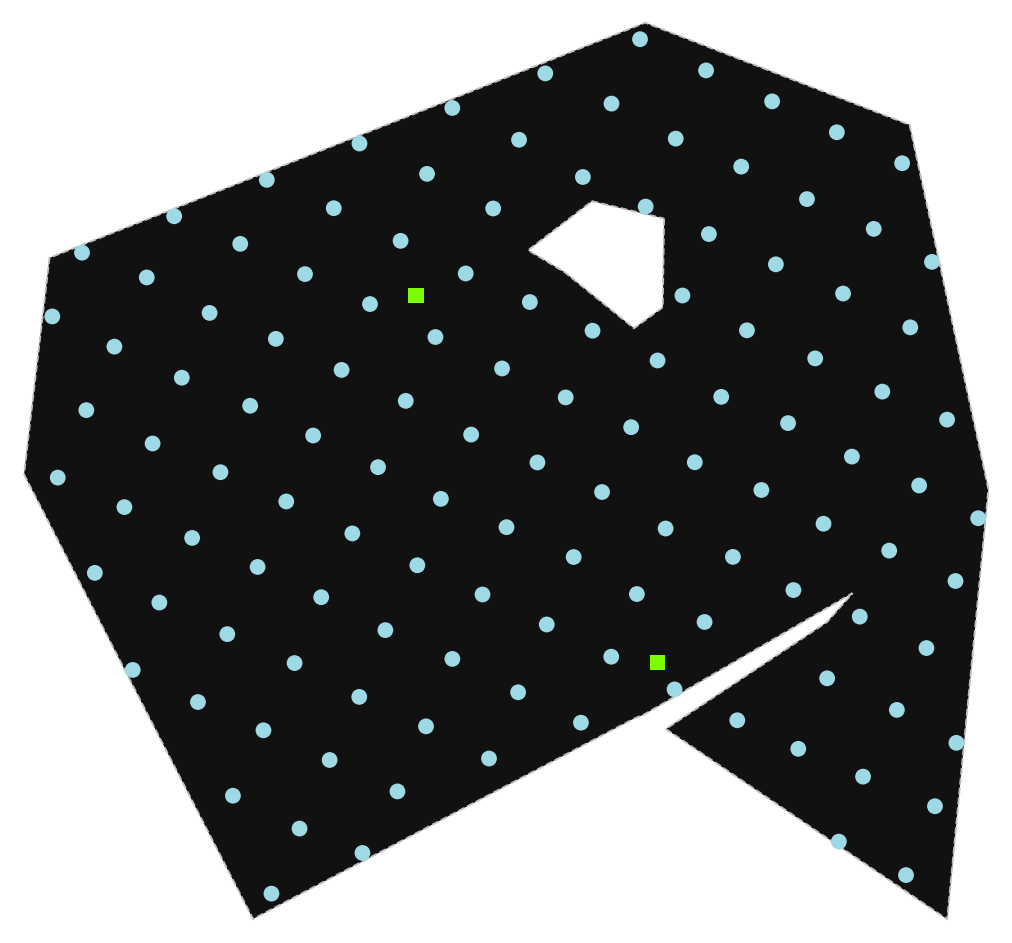

In [16]:
wfn.plot_location()

<Axes: >

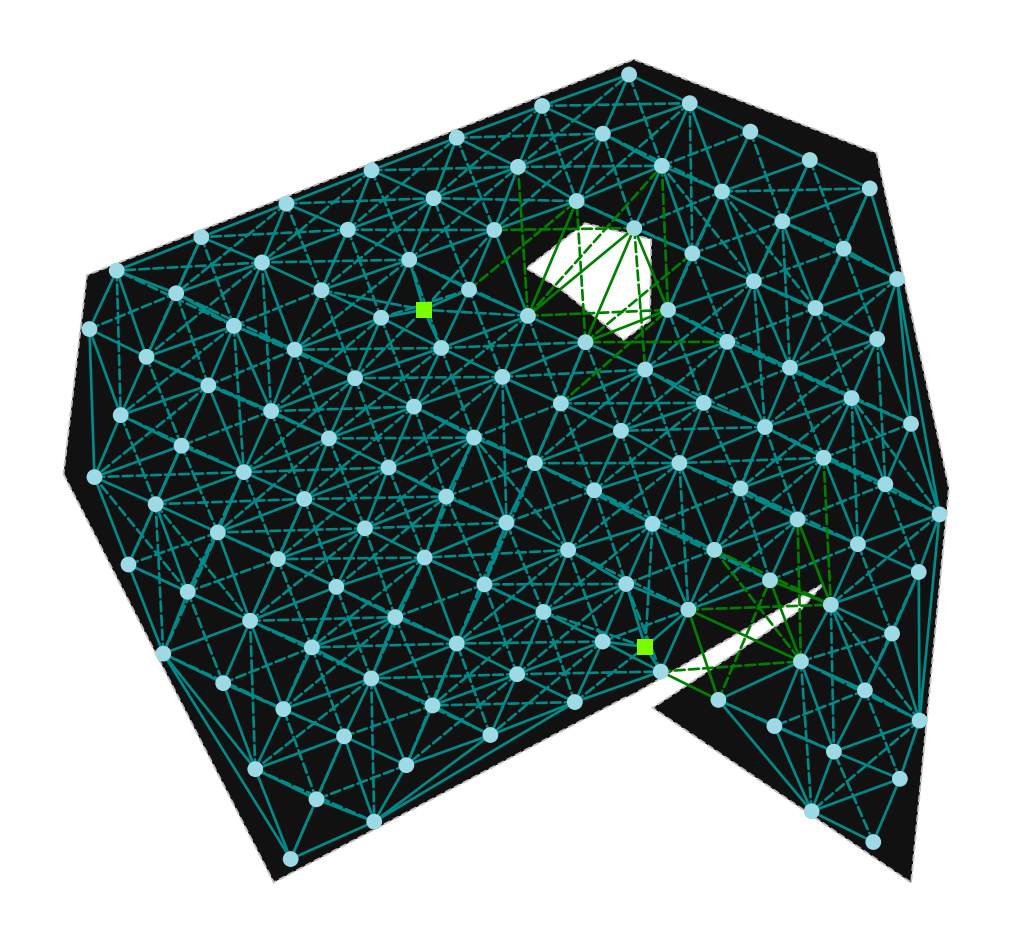

In [17]:
wfn.plot_available_links()

<Axes: >

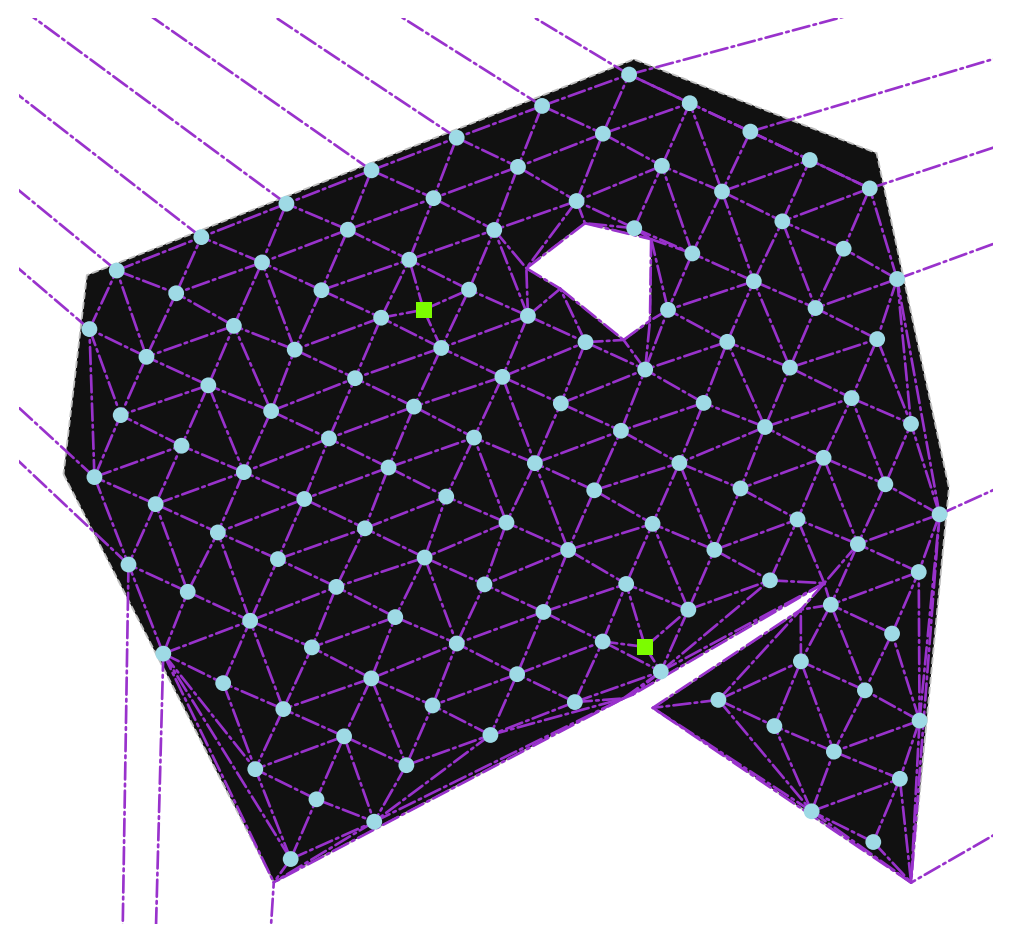

In [29]:
wfn.plot_navigation_mesh()

When the location has more than one substation, we cannot use the *HGS-CVRP* meta-heuristic. Instead, we may use a very fast heuristic: *Esau-Williams presolver* (**EW_presolver**).

**EW_presolver** has the downside of not limiting the number of feeders, thus the model to be warm-started must also have an unlimited number of feeders. This is usually not a problem, as most cable route sets produced by the MILP solver use the minimum number of feeders or only one more than the minimum.

### Generate the warm-start solution

In [19]:
router_pre_solver = Heuristic(solver='Esau_Williams')
res_pre_solver= wfn.optimize(router=router_pre_solver)

### Visualizing the warm-start solution

This section is unecessary in production.

wfn.plot() is plotting the final layout (which is stored in G object).

<Axes: >

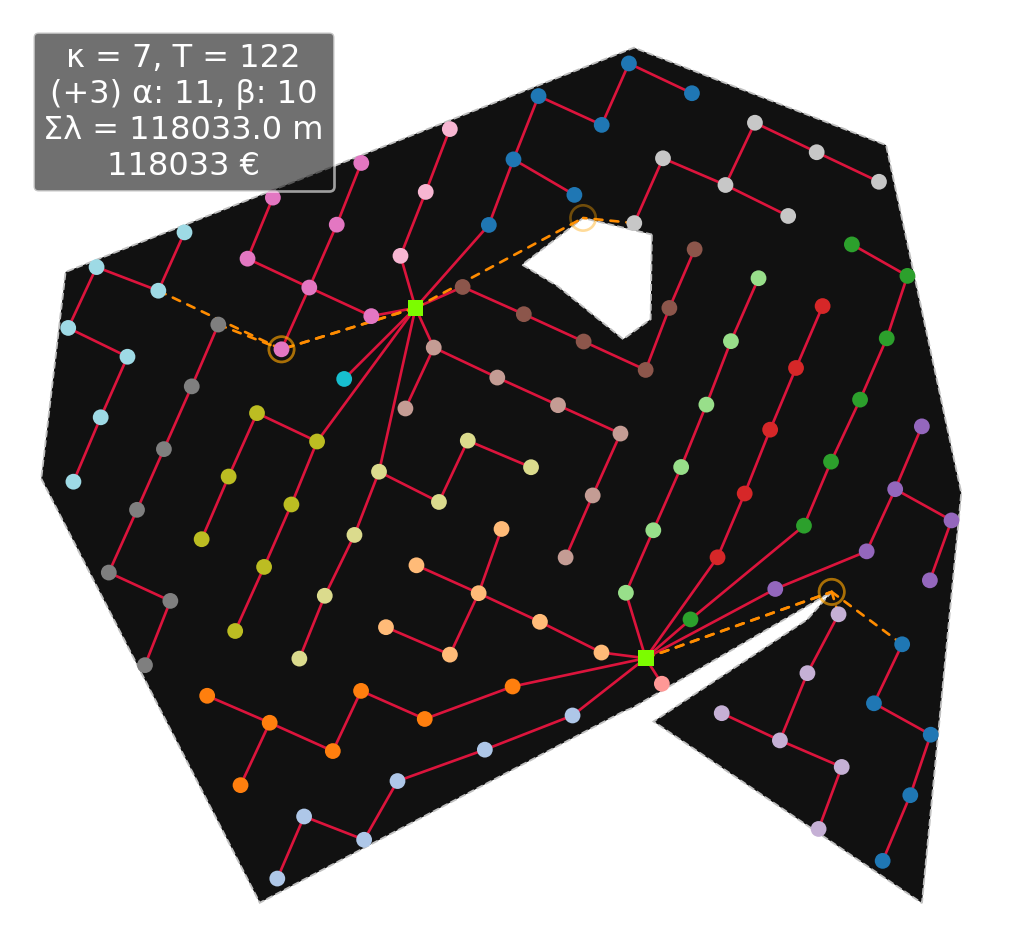

In [20]:
wfn.plot()

If we wanted to use that solution, we should add detours to the feeder cables that have forbidden crossings. There are two ways:

    - activate detours in the router: router = router_pre_solver = Heuristic(solver='EW', detours=True) - This should be done before running wfn.optimize()
    
    - create detours using wfn.create_detours() - This should be done after running wfn.optimize()

### Create MILP model and optimize it

In [21]:
cbcer = pyo.SolverFactory('cbc')
cbcer.available(), type(cbcer)

(True, pyomo.solvers.plugins.solvers.CBCplugin.CBCSHELL)

In [22]:
solver_options=dict(
    ratioGap=0.005,
    seconds=300,
    timeMode='elapsed',
    threads=8,
    # if repeatable results are desired, set the seed
    RandomCbcSeed=4321,
    # the parameters below and more can be experimented with
    # http://www.decom.ufop.br/haroldo/files/cbcCommandLine.pdf
    nodeStrategy='downFewest',
    # Heuristics
    Dins='on',
    VndVariableNeighborhoodSearch='on',
    pivotAndComplement='on',
    Rens='on',
    Rins='on',
    proximitySearch='off',
    # Cuts
    gomoryCuts='on',
    mixedIntegerRoundingCuts='on',
    flowCoverCuts='on',
    cliqueCuts='off',
    twoMirCuts='off',
    knapsackCuts='off',
    probingCuts='off',
    zeroHalfCuts='off',
    liftAndProjectCuts='off',
    residualCapacityCuts='off',
)


model_options = {"gateXing_constraint": False,
                 "branching": True,
                 "gates_limit": False}

router = MILP(solver='cbc', solver_options=solver_options, model_options=model_options)
res = wfn.optimize(router=router)

S is not None and the model is warmed up with the available S.
Solving "None": {R=2, T=122, κ=7}

Welcome to the CBC MILP Solver 
Version: 2.10.12 
Build Date: Mar  5 2025 

command line - C:\Users\amia\AppData\Local\miniconda3\envs\OptiWindNet\Library\bin\cbc.exe -ratioGap 0.005 -seconds 300 -timeMode elapsed -threads 8 -RandomCbcSeed 4321 -nodeStrategy downFewest -Dins on -VndVariableNeighborhoodSearch on -pivotAndComplement on -Rens on -Rins on -proximitySearch off -gomoryCuts on -mixedIntegerRoundingCuts on -flowCoverCuts on -cliqueCuts off -twoMirCuts off -knapsackCuts off -probingCuts off -zeroHalfCuts off -liftAndProjectCuts off -residualCapacityCuts off -printingOptions all -import C:\Users\amia\AppData\Local\Temp\tmp10lvyh25.pyomo.lp -mipstart \Users\amia\AppData\Local\Temp\tmppfs2b8mn.cbc.soln -stat=1 -solve -solu C:\Users\amia\AppData\Local\Temp\tmp10lvyh25.pyomo.soln (default strategy 1)
ratioGap was changed from 0 to 0.005
seconds was changed from 1e+100 to 300
Option for 

In [23]:
print(res)

[( 67,  80,  814.70976427, 6.,  True, 0,  814.70976427)
 ( 67,  55,  800.03812409, 5.,  True, 0,  800.03812409)
 ( 80,  -1,  627.35157607, 7., False, 0,  627.35157607)
 ( 55,  45,  829.7644244 , 4.,  True, 0,  829.7644244 )
 ( 68,  56,  811.31066799, 5.,  True, 0,  811.31066799)
 ( 68,  81,  854.85905271, 6.,  True, 0,  854.85905271)
 ( 81,  -1,  531.58818648, 7., False, 0,  531.58818648)
 ( 56,  57,  823.10266674, 4., False, 0,  823.10266674)
 ( 99, 100,  807.7252008 , 1.,  True, 0,  807.7252008 )
 (100, 108,  843.57868631, 5., False, 0,  843.57868631)
 (100,  -1, 1393.30183377, 7., False, 0, 1393.30183377)
 ( 18,  10,  849.24260374, 4.,  True, 0,  849.24260374)
 ( 18,  19,  845.70089275, 5.,  True, 0,  845.70089275)
 ( 19,  20,  845.24138564, 6.,  True, 0,  845.24138564)
 ( 10,   3,  783.53685299, 1.,  True, 0,  783.53685299)
 ( 10,   9,  830.14336111, 2.,  True, 0,  830.14336111)
 ( 25,  24,  819.54438562, 2.,  True, 0,  819.54438562)
 ( 25,  26,  813.88758438, 3.,  True, 0,  813.88

<Axes: >

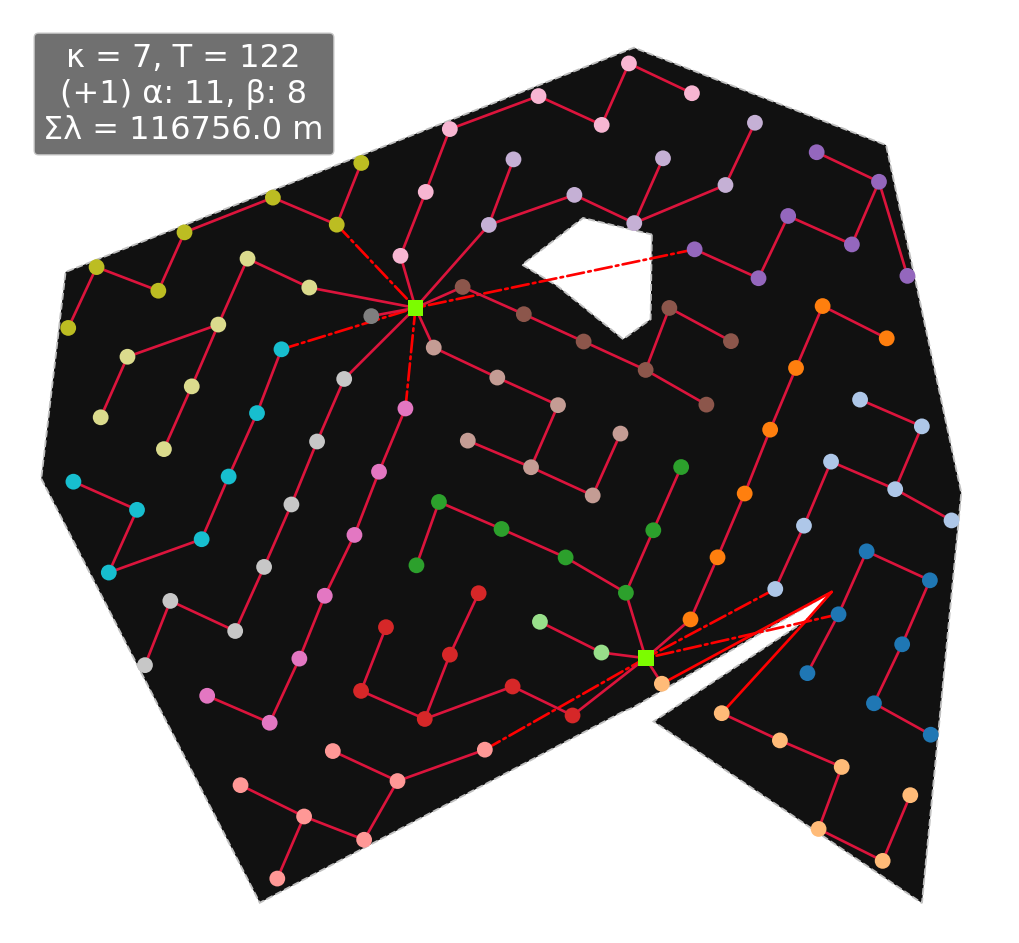

In [26]:
wfn.plot_selected_links()

### Trace routes from solution topology

<Axes: >

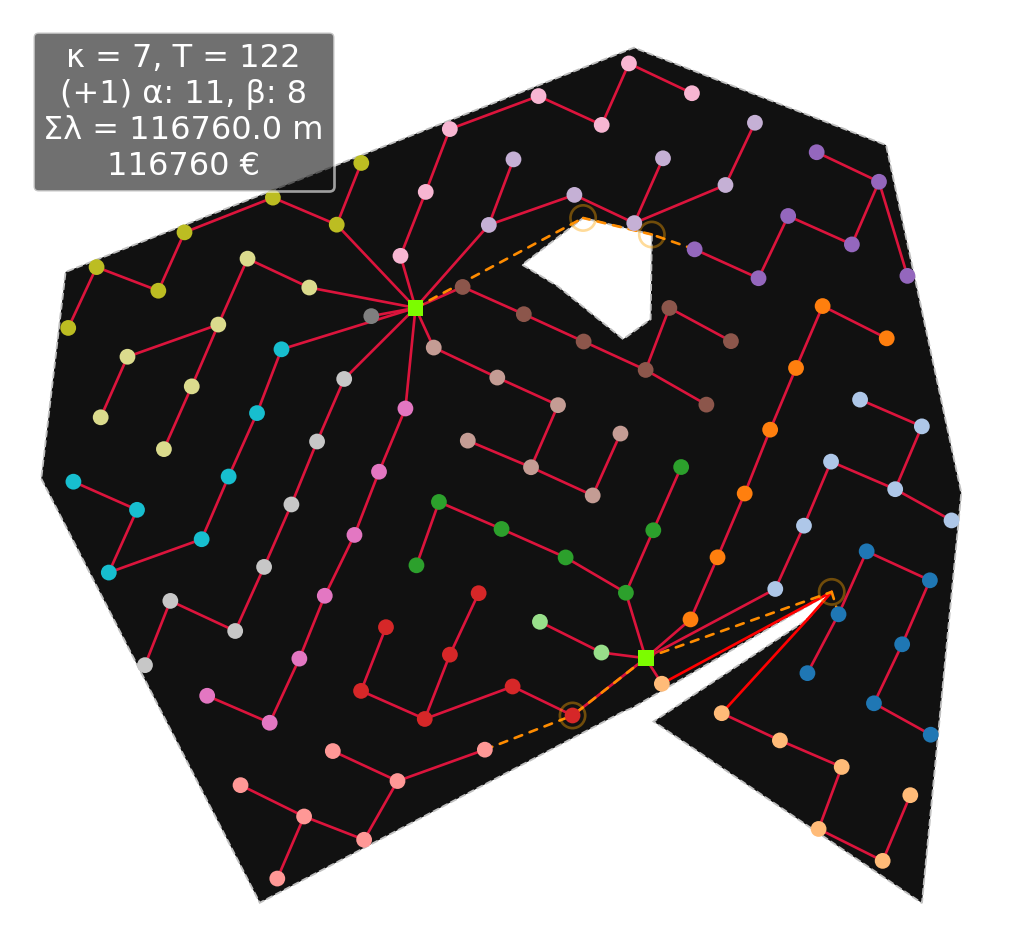

In [27]:
wfn.plot()

In [28]:
wfn.get_network_array()

array([( 67,  80,  814.70976427, 6.,  True, 0,  814.70976427),
       ( 67,  55,  800.03812409, 5.,  True, 0,  800.03812409),
       ( 80,  -1,  627.35157607, 7., False, 0,  627.35157607),
       ( 55,  45,  829.7644244 , 4.,  True, 0,  829.7644244 ),
       ( 68,  56,  811.31066799, 5.,  True, 0,  811.31066799),
       ( 68,  81,  854.85905271, 6.,  True, 0,  854.85905271),
       ( 81,  -1,  531.58818648, 7., False, 0,  531.58818648),
       ( 56,  57,  823.10266674, 4., False, 0,  823.10266674),
       ( 99, 100,  807.7252008 , 1.,  True, 0,  807.7252008 ),
       (100, 108,  843.57868631, 5., False, 0,  843.57868631),
       (100,  -1, 1393.30183377, 7., False, 0, 1393.30183377),
       ( 18,  10,  849.24260374, 4.,  True, 0,  849.24260374),
       ( 18,  19,  845.70089275, 5.,  True, 0,  845.70089275),
       ( 19,  20,  845.24138564, 6.,  True, 0,  845.24138564),
       ( 10,   3,  783.53685299, 1.,  True, 0,  783.53685299),
       ( 10,   9,  830.14336111, 2.,  True, 0,  830.143